# Análise Preditiva de Suicídios

## Descrição do dataset
Os dados foram coletados em forma de questionário através de redes sociais e emails. Alguns direcionados a grupos específicos de apoio (contra depressão). As questões abordadas foram baseadas nesta [pesquisa](https://www.kaggle.com/kingburrito666/the-demographic-rforeveralone-dataset). <br>

<b>Descrição das variáveis:</b><br>
* Q1: "Qual a sua idade?" <br>
* Q2: "Qual gênero você mais se identifica?" <br>
* Q3: "Qual sua orientação  sexual?" <br>
* Q4: "Qual o seu nível de renda anual?" <br>
* Q5: "Qual sua etnicidade?" <br>
* Q6: "Como você descreve sua massa corporal?" <br>
* Q7: "Você é virgem?" <br>
* Q8: "Você pagaria para ter uma relação sexual?" <br>
* Q9: "Quantos amigos você tem na vida real?" <br>
* Q10: "Você possui ansiedade/fobia social?" <br>
* Q11: "Você possui algum tipo de diagnóstico de transtorno mental?" <br>
* Q12: "Que tipo de ajuda você quer?" <br>
* Q13: "Você já tentou se suicidar?" <br>
* Q14: "Qual seu status empregatício? Atualmente você é..." <br>
* Q15: "Qual seu cargo atual?" <br>
* Q16: "Qual seu nível de educação?" <br>
* Q17: "O que você fez para se sentir melhor consigo mesmo?" <br>
* Q18: "Com quem você mora?" <br>
* Q19: "Seus pais são divorciados?" <br>


In [1]:
#!pip install --upgrade pip

In [2]:
#!pip install imblearn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)

## Funções úteis

In [4]:
from plot_metric.functions import BinaryClassification

In [5]:
def plot_roc_curve(ytest, predicted_yproba, figure_name):
    %matplotlib inline
    bc = BinaryClassification(ytest, predicted_yproba, labels=["Classe 0", "Classe 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.savefig(figure_name)
    plt.show()
    
    
def plot_resampling_comparing(confusion_matriz_os, confusion_matriz_us, figure_name):
    fig = plt.figure(figsize=(10,4))

    ax0 = fig.add_subplot(121)
    ax0.set_title('Oversampling')
    ax1 = fig.add_subplot(122)
    ax1.set_title('Undersampling')

    sns.heatmap(confusion_matriz_os, annot=True, cmap=sns.light_palette("black"), ax=ax0)
    sns.heatmap(confusion_matriz_us, annot=True, cmap=sns.light_palette("black"), ax=ax1)
    
    plt.savefig(figure_name)

In [6]:
def check_classifiers_scores(classifiers, Xtrain, ytrain):
    for key, classifier in classifiers.items():
        classifier.fit(Xtrain, ytrain)
        training_score = cross_val_score(classifier, Xtrain, ytrain, cv=5, n_jobs=-1)
        precision_score = cross_val_score(classifier, Xtrain, ytrain, cv=5, n_jobs=-1, scoring='precision')
        recall_score = cross_val_score(classifier, Xtrain, ytrain, cv=5, n_jobs=-1, scoring='recall')

        print(classifier.__class__.__name__, 
              "[Accuracy]:", round(training_score.mean(), 2) * 100, "%", 
              "[Precision]:", round(precision_score.mean(), 2),
              "[Recall]:", round(recall_score.mean(), 2)
        )

In [7]:
def show_feature_importance(importances, current_df):
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")

    for f in range(current_df.shape[1]):
        print("%d. %s (%f)" % (f + 1, current_df.columns[indices[f]], importances[indices[f]]))


def plot_feature_importance(importances, current_df, figure_name):
    indices = np.argsort(importances)
    f, ax = plt.subplots(figsize=(15, 8))
    ax = plt.gca()
    ax.set_facecolor('white')

    plt.title("Feature ranking", fontsize = 20)
    plt.barh(range(current_df.shape[1]), importances[indices], color="black", align="center")

    plt.yticks(range(current_df.shape[1]), current_df.columns[indices])
    plt.ylim([-1, current_df.shape[1]])
    plt.ylabel("Features", fontsize = 20)
    plt.xlabel("Importance", fontsize = 20)
    plt.savefig(figure_name)

## Dataset

In [8]:
survey_data = pd.read_csv('survey_data.csv')

In [9]:
df = survey_data.iloc[:, 1:20]
df.columns = ['Q{}'.format(x+1) for x in range(0, 19)]
df.isnull().sum()

Q1     0  
Q2     0  
Q3     0  
Q4     6  
Q5     0  
Q6     0  
Q7     0  
Q8     0  
Q9     0  
Q10    0  
Q11    84 
Q12    0  
Q13    0  
Q14    0  
Q15    111
Q16    0  
Q17    0  
Q18    0  
Q19    0  
dtype: int64

## 1. Pré-processamento

In [10]:
def check_values_column(series):
    return pd.DataFrame(series.str.strip().unique()).sort_values(by=0)

In [11]:
def replace_values(df, column_name, values_search, value_replace):
    for value in values_search:
        contains_value = df[column_name].str.lower().str.contains(value)
        df[column_name] = np.where(contains_value == True, value_replace, df[column_name])

In [12]:
def create_age_range(df, feature_name, age_start, age_end):
    current = age_start
    step = 4
    
    while (current < age_end):
        age_endd = current + step
        
        df.loc[df.Q1.between(current, age_endd), feature_name] = \
        '{} à {} anos'.format(current, age_endd)

        current += (1 + step)


### 1.1 Variável Q1 - "Qual a sua idade?"
Limpeza e feature para a variável idade. <br>

In [13]:
fig = plt.figure(figsize=(10,4))

ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

sns.distplot(df.Q1, kde=True, color='Black', ax=ax0);
sns.boxplot(x=df["Q1"], palette=sns.light_palette("black"), orient='v', ax=ax1)

plt.savefig('q1v2.png')

fig.show()

In [14]:
df.Q1.describe()

count    244.000000
mean     23.463115 
std      5.722193  
min      13.000000 
25%      19.000000 
50%      22.000000 
75%      27.000000 
max      47.000000 
Name: Q1, dtype: float64

#### 1.1.1 Feature por intervalo de idade

In [15]:
#create_age_range(df, 'Q1_FAIXA_IDADE', 10, 49)

In [16]:
#df.Q1_FAIXA_IDADE.value_counts()

### 1.2 Variável Q2 - "Qual gênero você mais se identifica?"

In [17]:
df.Q2.value_counts()

Feminino         156
Masculino        85 
Agenero          1  
Gênero fluído    1  
Não binário      1  
Name: Q2, dtype: int64

In [18]:
replace_values(df, 'Q2', ['agenero', 'não binário'], 'Não binário')

In [19]:
sns.countplot(x='Q2', data=df, palette='Blues')
plt.savefig('q2.png')

### 1.3 Variável Q3 - "Orientação sexual"
Limpeza e recategorização

In [20]:
df.Q3.value_counts(), df[df.Q3.isna()].shape

(Heterossexual               163
 Bissexual                   56 
 Homossexual                 15 
 Panssexual                  2  
 Pansexual                   2  
 Assexual                    2  
 Pansexual                   2  
 Não sei mt bem              1  
 Heterossexual bi-curioso    1  
 Name: Q3, dtype: int64, (0, 19))

In [21]:
replace_values(df, 'Q3', ['pansexual', 'panssexual'], 'Pansexual')
replace_values(df, 'Q3', ['bi-curioso', 'não sei'], 'Outros')

In [22]:
chart_q3 = sns.countplot(x='Q3', data=df, palette='Blues', order=df.Q3.value_counts().index)
chart_q3.set_xticklabels(chart_q3.get_xticklabels(), rotation=20)

plt.savefig('q3.png')

### 1.4 Variável Q4 - "Qual o seu nível de renda anual?"

In [23]:
df[df['Q4'].isna()]['Q14']

24     Estudante                               
112    Desempregado e procurando por um emprego
126    Estudante                               
151    Estudante                               
167    Estudante                               
184    Estudante                               
Name: Q14, dtype: object

In [24]:
df['Q4'].value_counts()

R$1,00 - R$9,999         101
R$10,000 - R$19,999      42 
R$20,000 - R$29,999      29 
R$50,000 - R$74,999      19 
R$200,000 ou mais        12 
R$30,000 - R$39,999      11 
R$40,000 - R$49,999      7  
R$75,000 - R$99,999      7  
R$125,000 - R$149,999    4  
R$100,000 - R$124,999    3  
R$175,000 - R$199,999    2  
R$150,000 - R$174,999    1  
Name: Q4, dtype: int64

In [25]:
chart_q4 = sns.countplot(x='Q4', data=df, palette='Blues', order=df.Q4.value_counts().index)
chart_q4.set_xticklabels(chart_q4.get_xticklabels(), rotation=90)
plt.savefig('q4.png')

#### 1.4.1 Substituindo valores pela moda

Baseado na análise, os registros são referente a estudantes e/ou desempregados

In [26]:
mode = df['Q4'].value_counts().index[0]

In [27]:
df['Q4'].fillna(mode, inplace=True)

### 1.5 Variável Q5 - "Qual sua etnicidade?"

In [28]:
chart_q5 = sns.countplot(x='Q5', data=df, palette='Blues', order=df.Q5.value_counts().index)
chart_q5.set_xticklabels(chart_q5.get_xticklabels(), rotation=15)
plt.savefig('q5.png')

### 1.6 Variável Q6 - "Como você descreve sua massa corporal?"

In [29]:
df.Q6.value_counts()

Peso normal                117
Acima do peso              71 
Abaixo do peso             30 
Obesidade I                16 
Obesidade II (severa)      5  
Muito abaixo do peso       3  
Obesidade III (mórbida)    2  
Name: Q6, dtype: int64

In [30]:
chart_q6 = sns.countplot(x='Q6', data=df, palette='Blues', order=df.Q6.value_counts().index)
chart_q6.set_xticklabels(chart_q6.get_xticklabels(), rotation=15)
plt.savefig('q6.png')

### 1.7 Variável Q7 - "Você é virgem?"

In [31]:
sns.countplot(x='Q7', data=df, palette='Blues', order=df.Q7.value_counts().index)
plt.savefig('q7.png')

In [32]:
df.Q7 = np.where(df.Q7 == 'Sim', 1, 0)

### 1.8 Variável Q8 - "Você pagaria para ter uma relação sexual?"

In [33]:
df.Q8.value_counts()

Não                                                                                                     196
Sim e não fiz                                                                                           18 
Sim                                                                                                     15 
Sim e já fiz                                                                                            11 
Talvez                                                                                                  1  
Já cogitei fortemente mas é caro e frio                                                                 1  
Se eu ganhasse muito bem e estivesse com muita vontade e achasse a pessoa adequada ao meu gosto, sim    1  
Não sei                                                                                                 1  
Name: Q8, dtype: int64

In [34]:
replace_values(df, 'Q8', ['cogitei'], 'Talvez')
replace_values(df, 'Q8', ['ganhasse'], 'Sim')

In [35]:
sns.countplot(x='Q8', data=df, palette='Blues', order=df.Q8.value_counts().index)
plt.savefig('q8.png')

### 1.9 Variável Q9 - "Quantos amigos você tem na vida real?"

In [36]:
df.Q9.describe()

count    244.000000
mean     15.323770 
std      40.952217 
min      0.000000  
25%      4.000000  
50%      7.000000  
75%      10.500000 
max      500.000000
Name: Q9, dtype: float64

In [37]:
ax = sns.distplot(df.Q9, bins=20, kde=False, color='Black');
ax.set_yscale('log')

In [38]:
df[df['Q9'] <= 20].Q9.describe()

count    223.000000
mean     7.547085  
std      5.292037  
min      0.000000  
25%      4.000000  
50%      6.000000  
75%      10.000000 
max      20.000000 
Name: Q9, dtype: float64

#### 1.9.1 Atribuindo a média sem outliers
Para os registros com valores maiores que 20 amigos, é substituído o número de amigos
pela média considerando até 20 amigos.

In [39]:
friends_mean_without_outliers = df[df['Q9'] <= 20].Q9.mean()

In [40]:
df['Q9_PROCESSADO'] = np.where(df['Q9'] > 20, friends_mean_without_outliers, df['Q9'])

In [41]:
df['Q9_PROCESSADO'].describe()

count    244.000000
mean     7.547085  
std      5.058203  
min      0.000000  
25%      4.000000  
50%      7.000000  
75%      10.000000 
max      20.000000 
Name: Q9_PROCESSADO, dtype: float64

In [42]:
ax = sns.distplot(df.Q9_PROCESSADO, bins=20, kde=False, color='Black');
ax.set_yscale('log')

In [43]:
fig = plt.figure(figsize=(10,4))

ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax0.set_yscale('log')
ax1.set_yscale('log')

sns.distplot(df.Q9, kde=False, bins=20, color='Black', ax=ax0);
sns.distplot(df.Q9_PROCESSADO, bins=20, kde=False, color='Black', ax=ax1);

plt.savefig('q9.png')

fig.show()

In [44]:
df = df.drop(columns='Q9')

### 1.10 Variável Q10 - "Você possui ansiedade/fobia social?"

In [45]:
sns.countplot(x='Q10', data=df, palette='Blues', order=df.Q10.value_counts().index)
plt.savefig('q10.png')

In [46]:
df.Q10 = np.where(df.Q10 == 'Sim', 1, 0)

### 1.11 Variável Q11 - "Você possui algum tipo de diagnóstico de transtorno mental?"
Esta variável envolve multipla seleção e digitação em campo livre.<br>
Os passos para tratamento serão:<br>
* Atribuir valor caso não tenha sido informado;
* Sobrescrever valores redundantes (digitados);
* Converter multipla seleção em colunas separadas;
* Converter as classes separadas para binário;
* Classificar valores digitados manualmente em categorias existentes e/ou criando novas (se necessário);

In [47]:
df[df['Q11'].isna()].shape

(84, 19)

In [48]:
df['Q11'].fillna('Sem resposta', inplace=True)

In [49]:
check_values_column(df['Q11'])

,0
21,Ansiedade de leve
12,"Apenas períodos de ansiedade + depressão , mas nao transtornos que me acompanharam durante a vida"
28,Nenhum
38,Nenhum (que eu saiba).
33,Nenhum diagnóstico
23,Não
39,Não possuo diagnóstico
30,Não tenho como responder pois evito procurar ajuda
45,"Não tenho nada diagnosticado, mas me sinto constantemente sobrecarregado e extremamente estressado. Pelo que leio, isso se chama Sindrome de Burn Out."
35,Não tenho transtorno mental


#### 1.11.1 Agrupando/sobrescrevendo valores redundantes

In [50]:
nenhum = 'Nenhum'

df.loc[df.Q11.str.lower().str.contains('nenhum'), 'Q11'] = nenhum
df.loc[df.Q11.str.lower().str.contains('não'), 'Q11'] = nenhum
df.loc[df.Q11.str.lower().str.contains('sem diagnóstico médico'), 'Q11'] = nenhum

outros = 'Outros'
df.loc[df.Q11.str.lower().str.contains('ansiedade de leve'), 'Q11'] = outros
df.loc[df.Q11.str.lower().str.contains('apenas períodos de ansiedade'), 'Q11'] = outros
df.loc[df.Q11.str.lower().str.contains('problemas psicológicos após lesão corporal'), 'Q11'] = outros
df.loc[df.Q11.str.lower().str.contains('tdah'), 'Q11'] = outros

df.Q11 = df.Q11.str.strip().str.replace('toc', 'TOC', regex=True)
df.Q11 = df.Q11.str.strip().str.replace('TOC', 'Transtornos de Ansiedade (Fobia Específica, Transtorno de Ansiedade Generalizada, Transtorno de Pânico, etc...)', regex=True)

In [51]:
check_values_column(df['Q11'])

,0
21,Nenhum
11,Outros
1,Sem resposta
0,"Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)"
29,"Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...);Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)"
19,"Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...);Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)"
15,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...)"
34,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...);Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...);Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)"
18,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...);Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)"
26,"Transtornos Alimentares (Anorexia, Bulimia, Transtorno de Ruminação, etc...);Transtornos de Ansiedade (Fobia Específica, Transtorno de Ansiedade Generalizada, Transtorno de Pânico, etc...)"


#### 1.11.2 Transformando variáveis categóricas em binário
Criando colunas binárias separadas para cada tipo de transtorno.

In [52]:
df_Q11 = pd.get_dummies(df['Q11'].str.strip().str.split(';', expand=True))

df['Q11_T1'] = df_Q11[['0_Transtornos Alimentares  (Anorexia, Bulimia, Transtorno de Ruminação, etc...)']].max(axis=1)

df['Q11_T2'] = df_Q11[['0_Transtornos de Ansiedade (Fobia Específica, Transtorno de Ansiedade Generalizada, Transtorno de Pânico, etc...)',
                       '1_Transtornos de Ansiedade (Fobia Específica, Transtorno de Ansiedade Generalizada, Transtorno de Pânico, etc...)']].max(axis=1)

df['Q11_T3'] = df_Q11[['0_Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)',
                       '1_Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)',
                       '2_Transtorno Bipolar e Transtornos Relacionados (Transtorno Bipolar Tipo I, Transtorno Bipolar Tipo II, Transtorno Ciclotímico, etc...)']].max(axis=1)

df['Q11_T4'] = df_Q11[['0_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)',
                       '1_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)',
                       '2_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)',
                       '3_Transtornos Depressivos (Transtorno Disruptivo da Desregulação do Humor, Transtorno Depressivo Persistente (Distimia), etc...)']].max(axis=1)

df['Q11_T5'] = df_Q11[['0_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '1_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '2_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '3_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)',
                       '4_Transtornos da Personalidade (Antissocial, Borderline, Esquizoide, Narcisista, Paranoide, etc...)']].max(axis=1)

df['Q11_T6'] = df_Q11[['0_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '1_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '2_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '3_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '4_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)',
                       '5_Transtornos Relacionados a Trauma e a Estressores (Transtorno de Apego Reativo, Transtorno de Interação Social Desinibida, Transtorno de Estresse Pós-traumático, Transtorno de Estresse Agudo, etc..)']].max(axis=1)


In [53]:
df['Q11_OUTROS'] = df_Q11[['0_Outros']].max(axis=1)
df['Q11_SEM_RESPOSTA'] = df_Q11[['0_Sem resposta']].max(axis=1)

In [54]:
df = df.drop(columns='Q11')

In [55]:
df.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q10', 'Q12', 'Q13',
       'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q9_PROCESSADO', 'Q11_T1',
       'Q11_T2', 'Q11_T3', 'Q11_T4', 'Q11_T5', 'Q11_T6', 'Q11_OUTROS',
       'Q11_SEM_RESPOSTA'],
      dtype='object')

In [56]:
df[df.Q11_OUTROS == 1]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q9_PROCESSADO,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_OUTROS,Q11_SEM_RESPOSTA
58,38,Masculino,Heterossexual,"R$125,000 - R$149,999",Branco,Peso normal,0,Não,0,Amigos;Terapia,Não,Empregado,Analista de sistemas,Pós-graduação completo,Outros exercícios físicos;Participando de encontros/clubes sociais,Com namorado(a),Sim,7.547085,0,0,0,0,0,0,1,0
63,26,Feminino,Bissexual,"R$30,000 - R$39,999",Branco,Peso normal,0,Não,0,Amigos;Terapia,Não,Estudante,Estagiária,Superior (graduação) completo,Indo à academia;Terapia;Voluntariado,Com amigo(s),Sim,15.000000,0,0,0,0,0,0,1,0
107,27,Masculino,Heterossexual,"R$1,00 - R$9,999",Branco,Peso normal,0,Não,0,Amigos;Não sei,Não,Autônomo,NaN,Pós-graduação incompleto,Indo à academia,Moro sozinho(a),Não,7.547085,0,0,0,0,0,0,1,0
177,20,Feminino,Bissexual,"R$200,000 ou mais",Branco,Peso normal,0,Não,0,Não sei,Não,Desempregado e não estou procurando por um emprego no momento,NaN,Ensino médio completo,Dormir,"Com meus pais (somente pai, somente mãe ou ambos)",Não,10.000000,0,0,0,0,0,0,1,0


### 1.12 Variável Q12 - "Que tipo de ajuda você quer?"

In [57]:
df.Q12.value_counts()

Amigos;Terapia                                                                                                          51
Terapia                                                                                                                 44
Não sei                                                                                                                 34
Não quero ajuda                                                                                                         29
Amigos                                                                                                                  18
Amigos;Conselheiro;Terapia                                                                                              17
Amigos;Não sei;Terapia                                                                                                  9 
Amigos;Não sei                                                                                                          8 
Não sei;Terapia 

In [58]:
df_Q12 = pd.get_dummies(df['Q12'].str.strip().str.split(';', expand=True))
df_Q12

,0_Amigos,0_Coaching de encontro,0_Conselheiro,0_Encontro arranjado,0_Não quero ajuda,0_Não sei,0_Terapia,1_Coaching de encontro,1_Conselheiro,1_Encontro arranjado,1_Já faço terapia e acompanhamento psiquiátrico,1_Não quero ajuda,1_Não sei,1_Terapia,1_eu já faço terapia. Obg,2_Conselheiro,2_Dinheiro,2_Encontro arranjado,2_Medicação,2_Não sei,"2_Psiquiatra, neurologista",2_Psiquiatria,2_Terapia,"3_Amigos compreensivos e, acima, de tudo, uma sociedade mais justa e compreensiva",3_Já faço medicamentos e já faço terapia,3_Não sei,3_Terapia,4_Mais curiosidade sobre o que são do que necessitar ajuda,4_Terapia
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [59]:
df['Q12_N1'] = df_Q12[['0_Amigos', '3_Amigos compreensivos e, acima, de tudo, uma sociedade mais justa e compreensiva']].max(axis=1)
df['Q12_N2'] = df_Q12[['0_Coaching de encontro', '1_Coaching de encontro']].max(axis=1)
df['Q12_N3'] = df_Q12[['0_Conselheiro', '1_Conselheiro', '2_Conselheiro']].max(axis=1)
df['Q12_N4'] = df_Q12[['0_Encontro arranjado', '1_Encontro arranjado', '2_Encontro arranjado']].max(axis=1)
df['Q12_N5'] = df_Q12[['0_Não quero ajuda', '1_Não quero ajuda']].max(axis=1)
df['Q12_N6'] = df_Q12[['0_Não sei', '1_Não sei', '2_Não sei', '3_Não sei']].max(axis=1)
df['Q12_N7'] = df_Q12[['0_Terapia', '1_Terapia', '2_Terapia', '3_Terapia', '4_Terapia', 
                       '1_Já faço terapia e acompanhamento psiquiátrico', 
                       '1_eu já faço terapia. Obg', '3_Já faço medicamentos e já faço terapia']].max(axis=1)

In [60]:
df['Q12_MEDICACAO'] = df_Q12[['2_Medicação', '3_Já faço medicamentos e já faço terapia']].max(axis=1)
df['Q12_PSIQUIATRA'] = df_Q12[['1_Já faço terapia e acompanhamento psiquiátrico', 
                               '2_Psiquiatra, neurologista', '2_Psiquiatria']].max(axis=1)
df['Q12_OUTROS'] = df_Q12['4_Mais curiosidade sobre o que são do que necessitar ajuda']

In [61]:
df = df.drop(columns='Q12')

In [62]:
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q9_PROCESSADO,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_OUTROS,Q11_SEM_RESPOSTA,Q12_N1,Q12_N2,Q12_N3,Q12_N4,Q12_N5,Q12_N6,Q12_N7,Q12_MEDICACAO,Q12_PSIQUIATRA,Q12_OUTROS
0,22,Feminino,Bissexual,"R$30,000 - R$39,999",Branco,Peso normal,0,Não,0,Sim,Empregado,Gerente comercial,Superior (graduação) incompleto,Terapia,Com amigo(s),Não,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,28,Masculino,Heterossexual,"R$75,000 - R$99,999",Branco,Peso normal,0,Não,0,Não,Empregado,Desenvolvedor de Software,Superior (graduação) incompleto,Indo à academia;Nada,Com amigo(s),Não,10.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,31,Masculino,Heterossexual,"R$20,000 - R$29,999",Negro,Peso normal,1,Sim,0,Não,Empregado,Marketing,Superior (graduação) completo,"Fumo maconha, toco, fumo maconha, transo",Com namorado(a),Não,9.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,30,Masculino,Heterossexual,"R$1,00 - R$9,999",Branco,Abaixo do peso,0,Sim,0,Não,Empregado,Professor,Pós-graduação completo,Dieta;Indo à academia;Procedimento cosmético,"Com meus pais (somente pai, somente mãe ou ambos)",Não,5.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,25,Feminino,Heterossexual,"R$1,00 - R$9,999",Branco,Peso normal,0,Não,0,Sim,Autônomo,NaN,Superior (graduação) completo,Indo à academia;Terapia,"Com meus pais (somente pai, somente mãe ou ambos)",Não,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### 1.13 Variável Q13 - "Você já tentou se suicidar?"
Label/target da pesquisa

In [63]:
chart_q13 = sns.countplot(x='Q13', data=df, palette='Blues', order=df.Q13.value_counts().index)
plt.savefig('q13.png')

In [64]:
df.Q13.value_counts() / df.Q13.count()

Não    0.647541
Sim    0.352459
Name: Q13, dtype: float64

In [65]:
df.Q13 = np.where(df.Q13 == 'Sim', 1, 0)

### 1.14 Variável Q14 - "Qual seu status empregatício? Atualmente você é...?"

In [66]:
chart_q14 = sns.countplot(x='Q14', data=df, palette='Blues', order=df.Q14.value_counts().index)
chart_q14.set_xticklabels(chart_q14.get_xticklabels(), rotation=90)
plt.savefig('q14.png')

### 1.15 Variável Q15 - "Qual seu cargo atual?"

In [67]:
df['Q15'].str.strip().value_counts()

Estudante                                                 20
Estagiário                                                4 
Professor                                                 3 
Estagiária                                                3 
Recepcionista                                             2 
Auxiliar de cartório                                      2 
Analista de sistema                                       2 
Bolsista                                                  2 
analista de sistemas                                      2 
professora                                                2 
Gerente                                                   2 
Desenvolvedor de Software                                 2 
Dev                                                       2 
Desenvolvedor de Sistemas                                 2 
Vendedora                                                 2 
Estágio                                                   2 
Gerente comercial       

#### 1.15.1 Agrupando valores

In [68]:
desenvolvimento = ['desenvolvedor', 'dev', 'analista', 'software', 'inteligência artificial']
ciencia_de_dados = ['dados', 'estatístico']
estudante = ['estudante', 'caloura', 'bolsista', 'escola', 'terceiro ano']
professor = ['professor', 'ministro aula casualmente']
estagiario = ['estagiári', 'estágio']
vendas = ['vendedor', 'vendas', 'atendente', 'call center', 'marketing', 'operador de caixa']
recepcionista = ['recepcionista', 'recepçao']
autonomo = ['dono', 'autônoma', 'empreendedor', 'empresária']
lideranca = ['gerente', 'diretor', 'líder']

replace_values(df, 'Q15', desenvolvimento, 'Desenvolvimento de Software')
replace_values(df, 'Q15', estudante, 'Estudante')
replace_values(df, 'Q15', estagiario, 'Estágio')
replace_values(df, 'Q15', professor, 'Educação')
replace_values(df, 'Q15', vendas, 'Vendas / Telemarketing')
replace_values(df, 'Q15', recepcionista, 'Recepcionista')
replace_values(df, 'Q15', autonomo, 'Empresário(a) / Empreendedor(a) / Autônomo(a)')
replace_values(df, 'Q15', ciencia_de_dados, 'Ciência de Dados')
replace_values(df, 'Q15', lideranca, 'Diretoria / Gerência / Liderança')
replace_values(df, 'Q15', ['redator'], 'Redator(a)')
replace_values(df, 'Q15', ['psic'], 'Psicologia')
replace_values(df, 'Q15', ['pesquisador'], 'Pesquisador(a)')
replace_values(df, 'Q15', ['coordenad'], 'Coordenador(a)')
replace_values(df, 'Q15', ['adm'], 'Administrativo')
replace_values(df, 'Q15', ['arquitet'], 'Arquiteto(a)')

df['Q15'].fillna('Sem resposta', inplace=True)

In [69]:
df.describe()

,Q1,Q7,Q10,Q13,Q9_PROCESSADO,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_OUTROS,Q11_SEM_RESPOSTA,Q12_N1,Q12_N2,Q12_N3,Q12_N4,Q12_N5,Q12_N6,Q12_N7,Q12_MEDICACAO,Q12_PSIQUIATRA,Q12_OUTROS
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.00000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,23.463115,0.196721,0.655738,0.352459,7.547085,0.102459,0.463115,0.069672,0.29918,0.102459,0.077869,0.016393,0.344262,0.491803,0.024590,0.114754,0.016393,0.147541,0.258197,0.610656,0.008197,0.012295,0.004098
std,5.722193,0.398337,0.476104,0.478718,5.058203,0.303874,0.499663,0.255117,0.45884,0.303874,0.268516,0.127244,0.476104,0.500960,0.155191,0.319380,0.127244,0.355373,0.438542,0.488604,0.090349,0.110426,0.064018
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,27.000000,0.000000,1.000000,1.000000,10.000000,0.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,47.000000,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
df[df['Q15'] == 'Sem resposta'].shape

(111, 35)

In [71]:
max(df.isnull().sum())

0

In [72]:
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q9_PROCESSADO,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_OUTROS,Q11_SEM_RESPOSTA,Q12_N1,Q12_N2,Q12_N3,Q12_N4,Q12_N5,Q12_N6,Q12_N7,Q12_MEDICACAO,Q12_PSIQUIATRA,Q12_OUTROS
0,22,Feminino,Bissexual,"R$30,000 - R$39,999",Branco,Peso normal,0,Não,0,1,Empregado,Diretoria / Gerência / Liderança,Superior (graduação) incompleto,Terapia,Com amigo(s),Não,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,28,Masculino,Heterossexual,"R$75,000 - R$99,999",Branco,Peso normal,0,Não,0,0,Empregado,Desenvolvimento de Software,Superior (graduação) incompleto,Indo à academia;Nada,Com amigo(s),Não,10.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,31,Masculino,Heterossexual,"R$20,000 - R$29,999",Negro,Peso normal,1,Sim,0,0,Empregado,Vendas / Telemarketing,Superior (graduação) completo,"Fumo maconha, toco, fumo maconha, transo",Com namorado(a),Não,9.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,30,Masculino,Heterossexual,"R$1,00 - R$9,999",Branco,Abaixo do peso,0,Sim,0,0,Empregado,Educação,Pós-graduação completo,Dieta;Indo à academia;Procedimento cosmético,"Com meus pais (somente pai, somente mãe ou ambos)",Não,5.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,25,Feminino,Heterossexual,"R$1,00 - R$9,999",Branco,Peso normal,0,Não,0,1,Autônomo,Sem resposta,Superior (graduação) completo,Indo à academia;Terapia,"Com meus pais (somente pai, somente mãe ou ambos)",Não,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### 1.16 Variável Q16 - "Qual seu nível de educação?"

In [73]:
df.Q16.value_counts()

Superior (graduação) incompleto                    79
Superior (graduação) completo                      45
Ensino médio completo                              38
Ensino médio incompleto                            30
Pós-graduação completo                             21
Pós-graduação incompleto                           7 
Ensino fundamental completo                        6 
Mestrado completo                                  5 
Mestrado incompleto                                3 
Grau acadêmico (colégio comunitário) completo      1 
Superior quase completo                            1 
estou cursando o ensino medio                      1 
Doutorado completo                                 1 
Doutorado incompleto                               1 
Não possuo                                         1 
Grau acadêmico (colégio comunitário) incompleto    1 
Ensino fundamental incompleto                      1 
Cursando o Ensino Médio.                           1 
Ensino tecnico              

In [74]:
replace_values(df, 'Q16', ['estou cursando o ensino medio', 'cursando o ensino médio.'], 'Ensino médio incompleto')
replace_values(df, 'Q16', ['superior quase completo'], 'Superior (graduação) incompleto')

### 1.17 Variável Q17 - "O que você fez para se sentir melhor consigo mesmo?

In [75]:
df.Q17.value_counts()

Nada                                                                                                                                                      53
Terapia                                                                                                                                                   22
Outros exercícios físicos                                                                                                                                 11
Indo à academia                                                                                                                                           7 
Outros exercícios físicos;Terapia                                                                                                                         6 
Dieta                                                                                                                                                     5 
Dieta;Indo à academia                                     

In [76]:
df_Q17 = pd.get_dummies(df['Q17'].str.strip().str.split(';', expand=True))
df_Q17.columns

Index(['0_Canto e ouço músicas', '0_Dieta', '0_Dormir',
       '0_Falo com meus amigos, me distraio com qualquer coisa',
       '0_Fumo maconha, toco, fumo maconha, transo', '0_Indo à academia',
       '0_Jogos', '0_Leitura e passes no centro espírita',
       '0_Meu filho e ficando de boas', '0_Nada',
       '0_Outros exercícios físicos',
       '0_Ouvir musicas animadas, assistir series que eu amo',
       '0_Participando de encontros/clubes sociais',
       '0_Pilates, yoga, meditação.', '0_Pintar e Dormir',
       '0_Procedimento cosmético',
       '0_Procedimentos estéticos, ajudo minha amiga na clínica dela todas as manhãs',
       '0_Qualquer coisa que me tire da realidade',
       '0_Resolver os problemas pessoais', '0_Saindo com amigos', '0_Terapia',
       '0_Ver pontos positivos rotineiramente', '0_Voluntariado', '0_compras',
       '0_foquei em fazer coisas que gostaria de fazer há tempos mas não fazia por achar que era incapaz ou que não estava pronta para fazê-las.',
    

In [77]:
df['Q17_A1'] = df_Q17['0_Dieta']
df['Q17_A2'] = df_Q17[['0_Indo à academia', '1_Indo à academia']].max(axis=1)
df['Q17_A3'] = df_Q17[['0_Nada', '1_Nada', '2_Nada']].max(axis=1)
df['Q17_A4'] = df_Q17[['0_Outros exercícios físicos', '1_Outros exercícios físicos', 
                       '2_Outros exercícios físicos', '3_Outros exercícios físicos',
                       '1_Corrida, jogos eletrônicos, leitura, culinária', 
                       '1_Exercício físico coletivo. Futebol, vôlei,etc']].max(axis=1)

df['Q17_A5'] = df_Q17[['0_Participando de encontros/clubes sociais', 
                       '1_Participando de encontros/clubes sociais',
                       '2_Participando de encontros/clubes sociais',
                       '3_Participando de encontros/clubes sociais',
                       '4_Participando de encontros/clubes sociais']].max(axis=1)

df['Q17_A6'] = df_Q17[['0_Procedimento cosmético', 
                       '1_Procedimento cosmético',
                       '2_Procedimento cosmético',
                       '3_Procedimento cosmético']].max(axis=1)

df['Q17_A7'] = df_Q17[['0_Terapia', '1_Terapia', '2_Terapia', '3_Terapia', '4_Terapia', '5_Terapia',
                       '2_Conversar com amigos, jogar, terapia ocupacional, pintar, artesanato, escrever, comprar roupas que me fazem confortável']].max(axis=1)

df['Q17_A8'] = df_Q17[['0_Voluntariado', '1_Voluntariado', '2_Voluntariado', '3_Voluntariado', 
                       '4_Voluntariado', '5_Voluntariado', '6_Voluntariado']].max(axis=1)

In [78]:
df['Q17_MUSICA_TEATRO_ARTE'] = df_Q17[['0_Canto e ouço músicas', '1_Tocar instrumentos/recorrer aos amigos',
                                       '0_Fumo maconha, toco, fumo maconha, transo', 
                                       '0_Ouvir musicas animadas, assistir series que eu amo',
                                       '0_Pintar e Dormir', '1_Grupo de teatro', '1_Teatro',
                                       '1_fazendo coisas sozinha, ouvindo música, desenhando...',
                                       '2_Conversar com amigos, jogar, terapia ocupacional, pintar, artesanato, escrever, comprar roupas que me fazem confortável', 
                                       '3_Dança, Piano', '3_Escrita']].max(axis=1)

df['Q17_AMIGOS'] = df_Q17[['0_Falo com meus amigos, me distraio com qualquer coisa', 
                           '1_Tocar instrumentos/recorrer aos amigos', '0_Saindo com amigos',
                           '2_Conversar com amigos, jogar, terapia ocupacional, pintar, artesanato, escrever, comprar roupas que me fazem confortável'
                          ]].max(axis=1)

df['Q17_DROGAS'] = df_Q17[['0_Fumo maconha, toco, fumo maconha, transo', '0_maconha', 
                           '3_Tracei metas e acatei práticas que me agradam, independente do consenso social sobre estas (fumar)']].max(axis=1)

df['Q17_JOGOS'] = df_Q17[['0_Jogos', '1_Corrida, jogos eletrônicos, leitura, culinária', '1_Jogos', 
                          '2_Conversar com amigos, jogar, terapia ocupacional, pintar, artesanato, escrever, comprar roupas que me fazem confortável']].max(axis=1)

df['Q17_LEITURA'] = df_Q17[['0_Leitura e passes no centro espírita', 
                            '1_Corrida, jogos eletrônicos, leitura, culinária', 
                            '2_Ler, obter conhecimento']].max(axis=1)

df['Q17_OUTROS'] = df_Q17[['0_Dormir', '0_Meu filho e ficando de boas',
                           '0_Pilates, yoga, meditação.', '0_Pintar e Dormir',
                           '0_Procedimentos estéticos, ajudo minha amiga na clínica dela todas as manhãs',
                           '0_Qualquer coisa que me tire da realidade', '0_Resolver os problemas pessoais',
                           '0_Ver pontos positivos rotineiramente', '0_compras',
                           '0_foquei em fazer coisas que gostaria de fazer há tempos mas não fazia por achar que era incapaz ou que não estava pronta para fazê-las.',
                           '1_Corrida, jogos eletrônicos, leitura, culinária',
                           '1_Eu me aceito como sou,ainda mais porque tenho pessoas maravilhosas comigo então não tem como eu querer fazer algo para me aceitar além do mais Deus me fez assim do jeitinho que sou então sou grata por tudo que tenho e sou.',
                           '1_Me afastando da minha mãe socialmente paranóica e pressionadora',
                           '1_Tento relaxar sozinha, pensar na raiz do problema e tentar melhorar',
                           '1_Trabalhar', '1_fazendo coisas sozinha, ouvindo música, desenhando...',
                           '2_Assistindo porno', '2_Conhecendo pessoas que eu tenha uma conexão e me entendam',
                           '2_Conversar com amigos, jogar, terapia ocupacional, pintar, artesanato, escrever, comprar roupas que me fazem confortável', 
                           '2_Tenho hobbies', '3_Atendimento psiquiátrico', '3_Meus gatos',
                           '0_Leitura e passes no centro espírita'
                          ]].max(axis=1)


In [79]:
df = df.drop(columns='Q17')

### 1.18 Variável Q18 - "Com quem você mora?"

In [80]:
chart_q18 = sns.countplot(x='Q18', data=df, palette='Blues', order=df.Q18.value_counts().index)
chart_q18.set_xticklabels(chart_q18.get_xticklabels(), rotation=90)
plt.savefig('q18.png')

### 1.19 Variável Q19 - "Seus pais são divorciados?"

In [81]:
sns.countplot(x='Q19', data=df, palette='Blues', order=df.Q19.value_counts().index)

In [82]:
df.Q19.value_counts() / df.Q19.count()

Não    0.598361
Sim    0.401639
Name: Q19, dtype: float64

In [83]:
df.Q19 = np.where(df.Q19 == 'Sim', 1, 0)

In [84]:
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q13,Q14,Q15,Q16,Q18,Q19,Q9_PROCESSADO,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_OUTROS,Q11_SEM_RESPOSTA,Q12_N1,Q12_N2,Q12_N3,Q12_N4,Q12_N5,Q12_N6,Q12_N7,Q12_MEDICACAO,Q12_PSIQUIATRA,Q12_OUTROS,Q17_A1,Q17_A2,Q17_A3,Q17_A4,Q17_A5,Q17_A6,Q17_A7,Q17_A8,Q17_MUSICA_TEATRO_ARTE,Q17_AMIGOS,Q17_DROGAS,Q17_JOGOS,Q17_LEITURA,Q17_OUTROS
0,22,Feminino,Bissexual,"R$30,000 - R$39,999",Branco,Peso normal,0,Não,0,1,Empregado,Diretoria / Gerência / Liderança,Superior (graduação) incompleto,Com amigo(s),0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,28,Masculino,Heterossexual,"R$75,000 - R$99,999",Branco,Peso normal,0,Não,0,0,Empregado,Desenvolvimento de Software,Superior (graduação) incompleto,Com amigo(s),0,10.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,31,Masculino,Heterossexual,"R$20,000 - R$29,999",Negro,Peso normal,1,Sim,0,0,Empregado,Vendas / Telemarketing,Superior (graduação) completo,Com namorado(a),0,9.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,30,Masculino,Heterossexual,"R$1,00 - R$9,999",Branco,Abaixo do peso,0,Sim,0,0,Empregado,Educação,Pós-graduação completo,"Com meus pais (somente pai, somente mãe ou ambos)",0,5.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
4,25,Feminino,Heterossexual,"R$1,00 - R$9,999",Branco,Peso normal,0,Não,0,1,Autônomo,Sem resposta,Superior (graduação) completo,"Com meus pais (somente pai, somente mãe ou ambos)",0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [85]:
df.shape

(244, 48)

## 2. Análise Exploratória

In [86]:
df.describe()

,Q1,Q7,Q10,Q13,Q19,Q9_PROCESSADO,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_OUTROS,Q11_SEM_RESPOSTA,Q12_N1,Q12_N2,Q12_N3,Q12_N4,Q12_N5,Q12_N6,Q12_N7,Q12_MEDICACAO,Q12_PSIQUIATRA,Q12_OUTROS,Q17_A1,Q17_A2,Q17_A3,Q17_A4,Q17_A5,Q17_A6,Q17_A7,Q17_A8,Q17_MUSICA_TEATRO_ARTE,Q17_AMIGOS,Q17_DROGAS,Q17_JOGOS,Q17_LEITURA,Q17_OUTROS
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.00000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,23.463115,0.196721,0.655738,0.352459,0.401639,7.547085,0.102459,0.463115,0.069672,0.29918,0.102459,0.077869,0.016393,0.344262,0.491803,0.024590,0.114754,0.016393,0.147541,0.258197,0.610656,0.008197,0.012295,0.004098,0.163934,0.213115,0.286885,0.286885,0.188525,0.102459,0.331967,0.131148,0.045082,0.016393,0.012295,0.016393,0.012295,0.094262
std,5.722193,0.398337,0.476104,0.478718,0.491237,5.058203,0.303874,0.499663,0.255117,0.45884,0.303874,0.268516,0.127244,0.476104,0.500960,0.155191,0.319380,0.127244,0.355373,0.438542,0.488604,0.090349,0.110426,0.064018,0.370977,0.410350,0.453237,0.453237,0.391934,0.303874,0.471887,0.338256,0.207910,0.127244,0.110426,0.127244,0.110426,0.292794
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,0.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,27.000000,0.000000,1.000000,1.000000,1.000000,10.000000,0.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,47.000000,1.000000,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.1 Convertendo Variáveis Categóricas

In [87]:
df = pd.get_dummies(df)

In [88]:
df.iloc[131]

Q1                                                            16.0
Q7                                                            1.0 
Q10                                                           1.0 
Q13                                                           0.0 
Q19                                                           1.0 
Q9_PROCESSADO                                                 3.0 
Q11_T1                                                        0.0 
Q11_T2                                                        1.0 
Q11_T3                                                        0.0 
Q11_T4                                                        0.0 
Q11_T5                                                        0.0 
Q11_T6                                                        0.0 
Q11_OUTROS                                                    0.0 
Q11_SEM_RESPOSTA                                              0.0 
Q12_N1                                                        

In [89]:
df.shape

(244, 139)

### 2.2 Correlações

In [90]:
#Renomeando para melhor visualização

df['Q11_SR'] = df.pop('Q11_SEM_RESPOSTA')

In [91]:
f, (ax1) = plt.subplots(1, 1, figsize=(50,50))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Matriz de correlações \n", fontsize=14)

Text(0.5, 1, 'Matriz de correlações \n')

In [92]:
corr_target = abs(corr["Q13"])

#Selecionado somente possíveis correlações com a variável label
relevant_features = corr_target[corr_target > 0.2]

In [93]:
df[relevant_features.index].corr()

,Q10,Q13,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q12_N7,Q17_A7,Q2_Feminino,Q2_Masculino,Q3_Bissexual,Q3_Heterossexual,Q11_SR
Q10,1.000000,0.281786,0.159476,0.551859,0.062763,0.416903,0.102587,0.178365,0.111362,0.217702,0.246186,-0.266816,0.108279,-0.162751,-0.491667
Q13,0.281786,1.000000,0.401381,0.312639,0.269842,0.435972,0.316514,0.201795,0.202039,0.372552,0.339732,-0.359371,0.250156,-0.281467,-0.335953
Q11_T1,0.159476,0.401381,1.000000,0.228268,0.119873,0.251480,0.376073,0.204426,0.048050,0.192304,0.197473,-0.247035,0.169122,-0.192304,-0.244809
Q11_T2,0.551859,0.312639,0.228268,1.000000,0.100951,0.380400,0.119855,0.282211,0.134781,0.235406,0.355235,-0.368557,0.118553,-0.095779,-0.672951
Q11_T3,0.062763,0.269842,0.119873,0.100951,1.000000,0.243063,0.279124,0.280918,0.086459,0.183106,0.104967,-0.098729,0.042046,-0.080555,-0.198286
Q11_T4,0.416903,0.435972,0.251480,0.380400,0.243063,1.000000,0.162936,0.311151,0.062816,0.299658,0.229781,-0.252295,0.154223,-0.204628,-0.473416
Q11_T5,0.102587,0.316514,0.376073,0.119855,0.279124,0.162936,1.000000,0.204426,0.020333,0.221003,0.141184,-0.161939,0.169122,-0.134907,-0.244809
Q11_T6,0.178365,0.201795,0.204426,0.282211,0.280918,0.311151,0.204426,1.000000,0.012469,0.087450,0.059002,-0.116167,0.059624,-0.054973,-0.210555
Q12_N7,0.111362,0.202039,0.048050,0.134781,0.086459,0.062816,0.020333,0.012469,1.000000,0.313005,0.170446,-0.192390,0.135982,-0.134521,-0.111362
Q17_A7,0.217702,0.372552,0.192304,0.235406,0.183106,0.299658,0.221003,0.087450,0.313005,1.000000,0.203225,-0.223161,0.049873,-0.168371,-0.254336


In [94]:
df.head()

,Q1,Q7,Q10,Q13,Q19,Q9_PROCESSADO,Q11_T1,Q11_T2,Q11_T3,Q11_T4,Q11_T5,Q11_T6,Q11_OUTROS,Q12_N1,Q12_N2,Q12_N3,Q12_N4,Q12_N5,Q12_N6,Q12_N7,Q12_MEDICACAO,Q12_PSIQUIATRA,Q12_OUTROS,Q17_A1,Q17_A2,Q17_A3,Q17_A4,Q17_A5,Q17_A6,Q17_A7,Q17_A8,Q17_MUSICA_TEATRO_ARTE,Q17_AMIGOS,Q17_DROGAS,Q17_JOGOS,Q17_LEITURA,Q17_OUTROS,Q2_Feminino,Q2_Gênero fluído,Q2_Masculino,Q2_Não binário,Q3_Assexual,Q3_Bissexual,Q3_Heterossexual,Q3_Homossexual,Q3_Outros,Q3_Pansexual,"Q4_R$1,00 - R$9,999","Q4_R$10,000 - R$19,999","Q4_R$100,000 - R$124,999",...,"Q15_Cat Sitter, Auxiliar de Veterinária e Curso de banho e tosa",Q15_Ciência de Dados,Q15_Consultora de Nutrição,Q15_Coordenador(a),Q15_Dentista,Q15_Desempregado,Q15_Desenvolvimento de Software,Q15_Designer gráfico,Q15_Diretoria / Gerência / Liderança,Q15_Educação,Q15_Empresário(a) / Empreendedor(a) / Autônomo(a),Q15_Estudante,Q15_Estágio,Q15_Expedição,Q15_Fotógrafo,Q15_Freelancer,Q15_Jovem aprendiz,Q15_Pesquisador(a),Q15_Projetista,Q15_Psicologia,Q15_Recepcionista,Q15_Redator(a),Q15_Secretaria,Q15_Sem resposta,"Q15_Tradutor, editor e corretor freelance (não registrado)",Q15_Tutora Pedagógica,Q15_Vendas / Telemarketing,Q16_Doutorado completo,Q16_Doutorado incompleto,Q16_Ensino fundamental completo,Q16_Ensino fundamental incompleto,Q16_Ensino médio completo,Q16_Ensino médio incompleto,Q16_Ensino tecnico,Q16_Grau acadêmico (colégio comunitário) completo,Q16_Grau acadêmico (colégio comunitário) incompleto,Q16_Mestrado completo,Q16_Mestrado incompleto,Q16_Não possuo,Q16_Pós-graduação completo,Q16_Pós-graduação incompleto,Q16_Superior (graduação) completo,Q16_Superior (graduação) incompleto,Q18_Com amigo(s),Q18_Com marido/mulher,"Q18_Com meus pais (somente pai, somente mãe ou ambos)",Q18_Com namorado(a),Q18_Com outro(s) familiar(es),Q18_Moro sozinho(a),Q11_SR
0,22,0,0,1,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,28,0,0,0,0,10.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
2,31,1,0,0,0,9.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,30,0,0,0,0,5.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,25,0,0,1,0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [95]:
f, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

relevant_corr = df[relevant_features.index].corr()
chart = sns.heatmap(relevant_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)

ax1.set_title("Matriz de correlações \n", fontsize=14)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

plt.savefig('correlation_greater_02.png')

In [96]:
df.shape

(244, 139)

## 3. Seleção de variáveis

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

In [98]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [99]:
backup_df = df.copy()

In [100]:
y = df.pop('Q13')

### 3.1 Greedy Feature Elimination
(Similar to Backward Stepwise Selection)

In [101]:
#estimator = SVR(kernel="linear")
#selector = RFE(estimator, 20, step=1)
#selector = selector.fit(X, y)

In [102]:
#selector.support_

In [103]:
#selector.ranking_

In [104]:
#selector.get_params

In [105]:
#support = pd.Series(selector.support_)

In [106]:
#df.columns[support.index[support]]

In [107]:
#df[df.columns[support.index[support]]]

### 3.2 Variance Threshold

In [108]:
from sklearn.feature_selection import VarianceThreshold

In [109]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(df)

array([[22.,  0.,  0., ...,  1.,  0.,  0.],
       [28.,  0.,  0., ...,  1.,  0.,  1.],
       [31.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [24.,  1.,  1., ...,  1.,  0.,  0.],
       [17.,  0.,  0., ...,  0.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.]])

In [110]:
sel.variances_

array([3.26092952e+01, 1.58022037e-01, 2.25745767e-01, 2.40325181e-01,
       2.54805558e+01, 9.19611664e-02, 2.48639479e-01, 6.48179253e-02,
       2.09671459e-01, 9.19611664e-02, 7.18052943e-02, 1.61246977e-02,
       2.49932814e-01, 2.39854878e-02, 1.01585595e-01, 1.61246977e-02,
       1.25772642e-01, 1.91531174e-01, 2.37755308e-01, 8.12953507e-03,
       1.21439129e-02, 4.08156410e-03, 1.37059930e-01, 1.67696856e-01,
       2.04582102e-01, 2.04582102e-01, 1.52983069e-01, 9.19611664e-02,
       2.21764983e-01, 1.13947863e-01, 4.30495834e-02, 1.61246977e-02,
       1.21439129e-02, 1.61246977e-02, 1.21439129e-02, 8.53769148e-02,
       2.30583177e-01, 4.08156410e-03, 2.27005509e-01, 8.12953507e-03,
       8.12953507e-03, 1.76834184e-01, 2.21764983e-01, 5.76961838e-02,
       8.12953507e-03, 2.39854878e-02, 2.46220774e-01, 1.42502016e-01,
       1.21439129e-02, 1.61246977e-02, 4.08156410e-03, 8.12953507e-03,
       1.04726552e-01, 4.67616232e-02, 4.30495834e-02, 2.78654931e-02,
      

In [111]:
sel.get_support()

array([ True, False,  True,  True,  True, False,  True, False,  True,
       False, False, False,  True, False, False, False, False,  True,
        True, False, False, False, False,  True,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False,  True, False, False,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [112]:
support = pd.Series(sel.get_support())

In [113]:
featured_df = df[df.columns[support.index[support]]]

In [114]:
featured_df

,Q1,Q10,Q19,Q9_PROCESSADO,Q11_T2,Q11_T4,Q12_N1,Q12_N6,Q12_N7,Q17_A2,Q17_A3,Q17_A4,Q17_A7,Q2_Feminino,Q2_Masculino,Q3_Bissexual,Q3_Heterossexual,"Q4_R$1,00 - R$9,999",Q5_Branco,Q5_Pardo,Q6_Acima do peso,Q6_Peso normal,Q14_Empregado,Q14_Estudante,Q15_Sem resposta,Q16_Superior (graduação) incompleto,"Q18_Com meus pais (somente pai, somente mãe ou ambos)",Q11_SR
0,22,0,0,0.000000,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0
1,28,0,0,10.000000,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1
2,31,0,0,9.000000,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0
3,30,0,0,5.000000,1,0,1,0,1,1,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,1,0
4,25,0,0,5.000000,0,0,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,0,0,1,0,1,0
5,24,1,0,7.000000,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0
6,32,0,1,10.000000,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1
7,26,0,0,10.000000,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1
8,35,0,1,20.000000,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1
9,25,1,1,0.000000,1,1,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0


In [115]:
featured_df.columns

Index(['Q1', 'Q10', 'Q19', 'Q9_PROCESSADO', 'Q11_T2', 'Q11_T4', 'Q12_N1',
       'Q12_N6', 'Q12_N7', 'Q17_A2', 'Q17_A3', 'Q17_A4', 'Q17_A7',
       'Q2_Feminino', 'Q2_Masculino', 'Q3_Bissexual', 'Q3_Heterossexual',
       'Q4_R$1,00 - R$9,999', 'Q5_Branco', 'Q5_Pardo', 'Q6_Acima do peso',
       'Q6_Peso normal', 'Q14_Empregado', 'Q14_Estudante', 'Q15_Sem resposta',
       'Q16_Superior (graduação) incompleto',
       'Q18_Com meus pais (somente pai, somente mãe ou ambos)', 'Q11_SR'],
      dtype='object')

In [116]:
X = featured_df

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [118]:
print("Full Dataset:", X.shape)
print("Treinamento:", X_train.shape)
print("Test:", X_test.shape)

Full Dataset: (244, 28)
Treinamento: (170, 28)
Test: (74, 28)


In [119]:
backup_df['Q13'].value_counts() / backup_df.shape[0]

0    0.647541
1    0.352459
Name: Q13, dtype: float64

In [120]:
y_train.value_counts() / y_train.shape

0    0.635294
1    0.364706
Name: Q13, dtype: float64

## 4. Desenvolvimento do modelo

### 4.1 Cross Validation

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [123]:
classifiers = {
    "LogisticRegression": LogisticRegression(), # Paramétrico
    "KNN": KNeighborsClassifier(), # Não paramétrico
    "SVC": SVC(), # Não paramétrico
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=17) # Não paramétrico
}

In [124]:
check_classifiers_scores(classifiers, X_train, y_train)

/Users/claytonrm/Environments/dsenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression [Accuracy]: 72.0 % [Precision]: 0.63 [Recall]: 0.56
KNeighborsClassifier [Accuracy]: 70.0 % [Precision]: 0.63 [Recall]: 0.41
SVC [Accuracy]: 64.0 % [Precision]: 0.0 [Recall]: 0.0
RandomForestClassifier [Accuracy]: 72.0 % [Precision]: 0.67 [Recall]: 0.53


### 4.2 Avaliando predições do modelo
Escolhendo o modelo com melhores métricas e analisando as predições

In [125]:
# Escolhendo o modelo com melhor acurácia
lr = classifiers['LogisticRegression']

In [126]:
#rf.predict(X_train)

predicted_y_proba = lr.predict_proba(X_test)[:, 1]
predicted_y = lr.predict(X_test)

lr_mc = confusion_matrix(y_test, predicted_y)

sns.heatmap(lr_mc, annot=True, cmap=sns.light_palette("black"))
plt.savefig('confusion_matriz_lr.png')

In [127]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        50
           1       0.60      0.38      0.46        24

    accuracy                           0.72        74
   macro avg       0.67      0.63      0.63        74
weighted avg       0.70      0.72      0.70        74



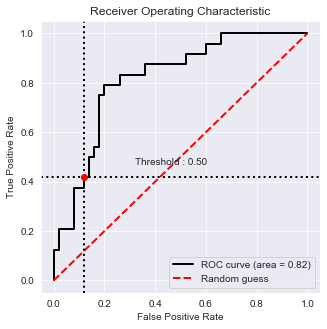

In [128]:
plot_roc_curve(y_test, predicted_y_proba, 'roc_curve_lr.png')

### 4.3 Over-sampling

In [129]:
from imblearn.over_sampling import SMOTE

In [130]:
y_train.value_counts()

0    108
1    62 
Name: Q13, dtype: int64

In [131]:
oversample = SMOTE(sampling_strategy='minority', random_state=17)
X_res, y_res = oversample.fit_resample(X_train, y_train)

In [132]:
y_res.value_counts()

1    108
0    108
Name: Q13, dtype: int64

In [133]:
classifiers_v2 ={
    "LogisticRegression": LogisticRegression(), # Paramétrico
    "KNN": KNeighborsClassifier(), # Não paramétrico
    "SVC": SVC(), # Não paramétrico
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=17) # Não paramétrico
}

check_classifiers_scores(classifiers_v2, X_res, y_res)

/Users/claytonrm/Environments/dsenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression [Accuracy]: 72.0 % [Precision]: 0.73 [Recall]: 0.7
KNeighborsClassifier [Accuracy]: 74.0 % [Precision]: 0.72 [Recall]: 0.79
SVC [Accuracy]: 65.0 % [Precision]: 0.63 [Recall]: 0.74
RandomForestClassifier [Accuracy]: 79.0 % [Precision]: 0.77 [Recall]: 0.83


#### 4.3.1 Anáise modelo com oversample 

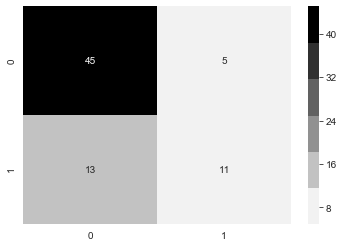

In [134]:
rf = classifiers_v2['RandomForest']

predicted_y_proba = rf.predict_proba(X_test)[:, 1]
predicted_y = rf.predict(X_test)

rf_mc = confusion_matrix(y_test, predicted_y)

sns.heatmap(rf_mc, annot=True, cmap=sns.light_palette("black"))
plt.savefig('confusion_matriz_rf.png')

In [135]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.69      0.46      0.55        24

    accuracy                           0.76        74
   macro avg       0.73      0.68      0.69        74
weighted avg       0.75      0.76      0.74        74



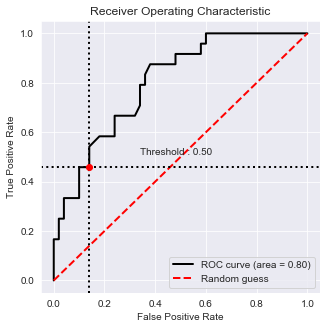

In [136]:
plot_roc_curve(y_test, predicted_y_proba, 'roc_curve_rf.png')

#### 4.3.2 Feature Importance

In [137]:
show_feature_importance(rf.feature_importances_, featured_df)

Feature ranking:
1. Q9_PROCESSADO (0.123102)
2. Q1 (0.108649)
3. Q2_Masculino (0.075092)
4. Q3_Heterossexual (0.062546)
5. Q11_SR (0.051236)
6. Q11_T4 (0.043727)
7. Q14_Estudante (0.038075)
8. Q6_Peso normal (0.033240)
9. Q17_A7 (0.033022)
10. Q12_N7 (0.031691)
11. Q11_T2 (0.029680)
12. Q16_Superior (graduação) incompleto (0.029267)
13. Q14_Empregado (0.029252)
14. Q17_A4 (0.025727)
15. Q10 (0.025360)
16. Q2_Feminino (0.024987)
17. Q12_N1 (0.024792)
18. Q19 (0.022973)
19. Q17_A2 (0.022477)
20. Q4_R$1,00 - R$9,999 (0.022386)
21. Q18_Com meus pais (somente pai, somente mãe ou ambos) (0.020442)
22. Q15_Sem resposta (0.020272)
23. Q5_Branco (0.019909)
24. Q6_Acima do peso (0.018851)
25. Q12_N6 (0.016817)
26. Q17_A3 (0.016744)
27. Q3_Bissexual (0.016073)
28. Q5_Pardo (0.013611)


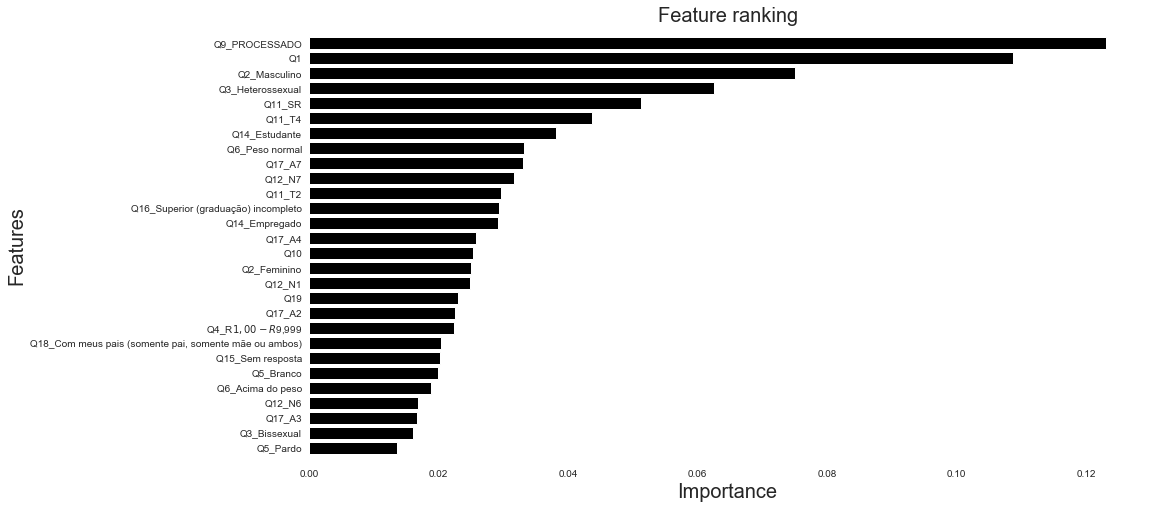

In [138]:
plot_feature_importance(rf.feature_importances_, featured_df, 'feature_importance_rf')

### 4.4 Under-sampling 

In [139]:
y_train.value_counts()

0    108
1    62 
Name: Q13, dtype: int64

In [140]:
undersampling_df = X_train.copy()
undersampling_df['LABEL'] = y_train

In [141]:
suicide_tries_df = undersampling_df.loc[undersampling_df['LABEL'] == 1]
non_suicide_tries_df = undersampling_df.loc[undersampling_df['LABEL'] == 0][:suicide_tries_df.shape[0]]

normal_distributed_df = pd.concat([suicide_tries_df, non_suicide_tries_df]).sample(frac=1, random_state=42)

normal_distributed_df['LABEL'].value_counts()

1    62
0    62
Name: LABEL, dtype: int64

In [142]:
y_under_resambled = normal_distributed_df.pop('LABEL')
X_under_resambled = normal_distributed_df

In [143]:
classifiers_v3 = {
    "LogisticRegression": LogisticRegression(), # Paramétrico
    "KNN": KNeighborsClassifier(), # Não paramétrico
    "SVC": SVC(), # Não paramétrico
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=17) # Não paramétrico
}

check_classifiers_scores(classifiers_v3, X_under_resambled, y_under_resambled)

/Users/claytonrm/Environments/dsenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression [Accuracy]: 70.0 % [Precision]: 0.69 [Recall]: 0.71
KNeighborsClassifier [Accuracy]: 56.00000000000001 % [Precision]: 0.59 [Recall]: 0.5
SVC [Accuracy]: 65.0 % [Precision]: 0.62 [Recall]: 0.76
RandomForestClassifier [Accuracy]: 73.0 % [Precision]: 0.72 [Recall]: 0.74


#### 4.4.1 Análise modelo com undersampling

In [144]:
rfus = classifiers_v3['RandomForest']

predicted_y_proba = rfus.predict_proba(X_test)[:, 1]
predicted_y = rfus.predict(X_test)

rfus_mc = confusion_matrix(y_test, predicted_y)

In [145]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.62      0.67      0.64        24

    accuracy                           0.76        74
   macro avg       0.72      0.73      0.73        74
weighted avg       0.76      0.76      0.76        74



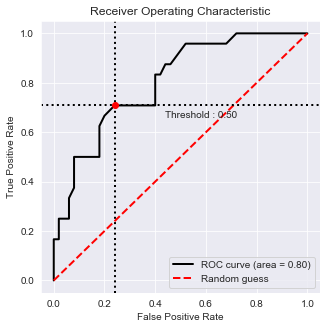

In [146]:
plot_roc_curve(y_test, predicted_y_proba, 'roc_curve_rf_undersample.png')

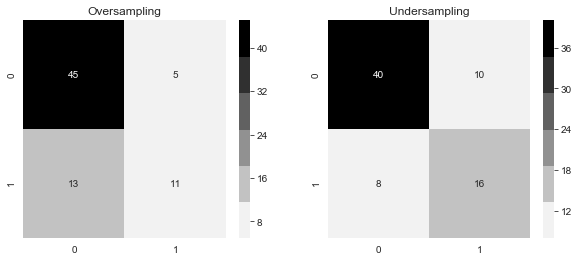

In [147]:
plot_resampling_comparing(rf_mc, rfus_mc, 'confusion_matriz_comparing.png')

#### 4.4.2 Feature Importance

In [148]:
show_feature_importance(rfus.feature_importances_, featured_df)

Feature ranking:
1. Q9_PROCESSADO (0.103499)
2. Q17_A7 (0.101605)
3. Q1 (0.095307)
4. Q11_T4 (0.068847)
5. Q12_N7 (0.049659)
6. Q11_T2 (0.037374)
7. Q2_Feminino (0.034502)
8. Q2_Masculino (0.031812)
9. Q3_Heterossexual (0.031291)
10. Q16_Superior (graduação) incompleto (0.031167)
11. Q19 (0.030498)
12. Q10 (0.027938)
13. Q11_SR (0.025580)
14. Q4_R$1,00 - R$9,999 (0.024341)
15. Q14_Estudante (0.024294)
16. Q18_Com meus pais (somente pai, somente mãe ou ambos) (0.024064)
17. Q6_Peso normal (0.023907)
18. Q5_Branco (0.023834)
19. Q17_A3 (0.023638)
20. Q12_N1 (0.023447)
21. Q14_Empregado (0.023223)
22. Q15_Sem resposta (0.022719)
23. Q6_Acima do peso (0.022651)
24. Q3_Bissexual (0.022258)
25. Q17_A4 (0.020742)
26. Q12_N6 (0.019832)
27. Q5_Pardo (0.016691)
28. Q17_A2 (0.015279)


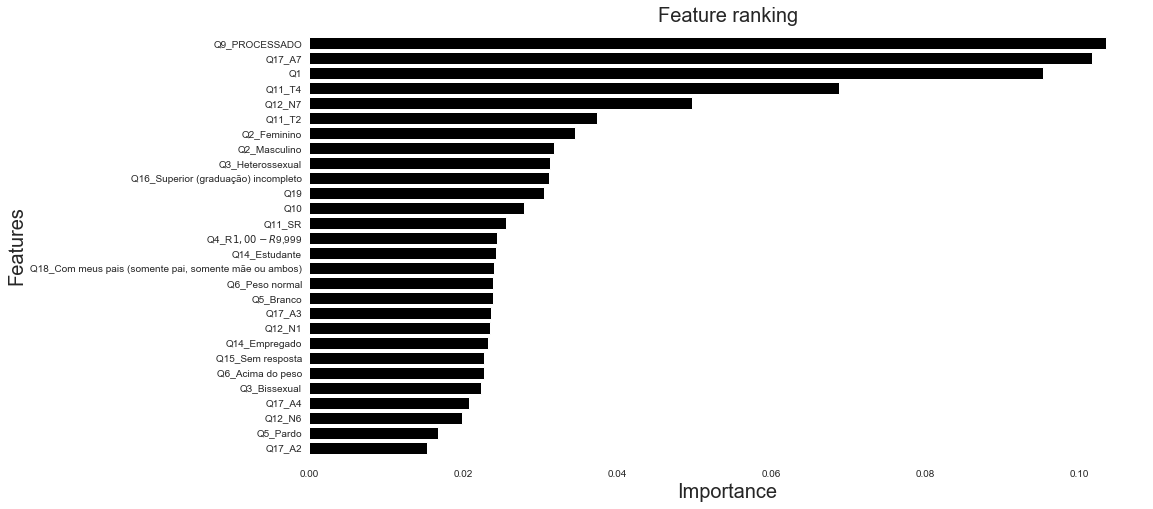

In [149]:
plot_feature_importance(rfus.feature_importances_, featured_df, 'feature_importance_rfus')